In [23]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

### Define static values and load data

In [24]:
# Baseline was estimate using randomly_shuffled_evaluation.py (run 10 x)
baseline = dict({
    "accuracy": 0.2501,
    "kappa": 0.0174,
    "f1-score": 0.1717
})

metrics = ["accuracy", "kappa", "f1-score"]
boxplot_kwargs = {'boxprops': dict(alpha=0.5), 'fliersize': 3}

In [25]:
def add_local_all(df):
    """
    Add all local runs to one new column in the given df
    """
    local_rows = df[df['mode'].str.contains('TMA|spl')].copy()
    local_rows['mode'] = 'z_local_all' # adding prefix z_* to place as last bar in plots
    df = pd.concat([df, local_rows], ignore_index=True)
    return df

In [26]:
folder = "run_results"
equal_df = add_local_all(pd.read_csv(os.path.join(folder, "equal.csv")))
nonIID_df = add_local_all(pd.read_csv(os.path.join(folder, "non-IID.csv")))
TMA_df = add_local_all(pd.read_csv(os.path.join(folder, "TMA.csv")))

equal_df["dataset"] = "equal"
nonIID_df["dataset"] = "non-IID"
TMA_df["dataset"] = "TMA"
full_df = pd.concat([equal_df, nonIID_df, TMA_df], ignore_index=True)

### Compare centralized, federated, and local for equal data

In [27]:
def calc_mean(df):
    equal_means_dict = dict({m: list() for m in metrics})
    grouped = df.groupby('mode')
    for mode, group in grouped:
        if True:
            print(f"\n{mode}")
            print(' '.join(metrics))
            for metric in metrics:
                mean = group[metric].mean()
                equal_means_dict[metric].append(mean)
                print(f"{mean:.3}", end="\t")
            print()

    return equal_means_dict

equal_means_dict = calc_mean(equal_df)


central
accuracy kappa f1-score
0.529	0.709	0.444	

federated
accuracy kappa f1-score
0.511	0.708	0.448	

spl_1
accuracy kappa f1-score
0.488	0.669	0.409	

spl_2
accuracy kappa f1-score
0.503	0.668	0.422	

spl_3
accuracy kappa f1-score
0.51	0.685	0.427	

z_local_all
accuracy kappa f1-score
0.5	0.674	0.419	


In [28]:
def best_epochs(df):
    print("mean best epoch per mode:")
    for mode in df["mode"].unique():
        m_df = df[df["mode"] == mode]
        fill = "\t\t" if mode[:3] == "TMA" else "\t"
        print(f"{mode}{fill}{round(m_df["best_epoch"].mean())}")

best_epochs(equal_df)

mean best epoch per mode:
central	320
federated	427
spl_1	410
spl_2	375
spl_3	414
z_local_all	400


## Figure 4

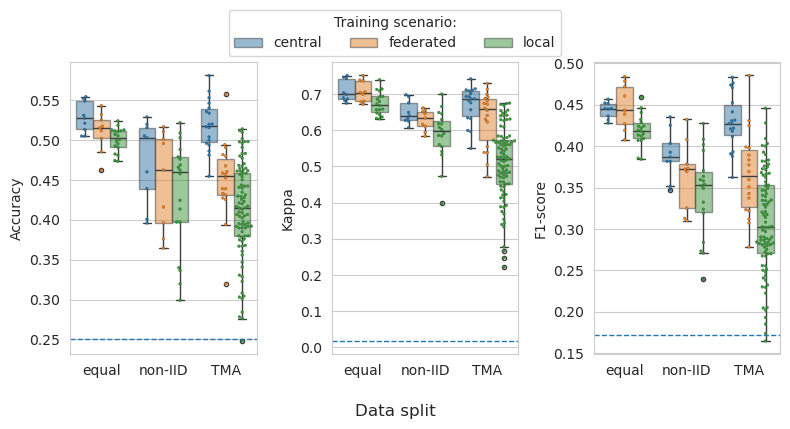

In [38]:
def create_figure4(df):
    df=df[df["mode"].isin(["central", "federated", "z_local_all"])]
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    for i, metric in enumerate(metrics):
        sns.boxplot(x='dataset', y=metric, hue="mode", dodge=True, data=df, ax=axes[i], **boxplot_kwargs)
        sns.swarmplot(x='dataset', y=metric, hue="mode", dodge=True, data=df, ax=axes[i], edgecolor="auto", linewidth=0.2, size=2)

        axes[i].axhline(baseline[metric], linestyle="--", linewidth=1)
        axes[i].set_xlabel("")
        axes[i].set_ylabel(f"{metric.capitalize()}")
        axes[i].legend().remove()

    fig.supxlabel("Data split")

    handles, labels = axes[0].get_legend_handles_labels()
    new_handles = [handles[0], handles[1], handles[2]]
    new_labels = [labels[0], labels[1], "local"]
    fig.legend(new_handles, new_labels, loc='upper center', title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(os.path.join("run_results", "Figure4.png"), dpi=300, bbox_inches='tight')
    
create_figure4(full_df)

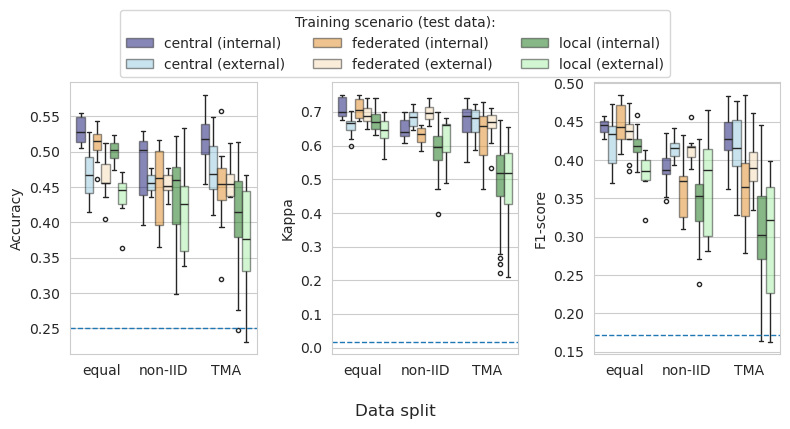

In [40]:
def create_figure5(df):
    df = df[df["mode"].isin(["central", "federated", "z_local_all"])]
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    custom_colors = ["navy", "skyblue", "darkorange", "navajowhite", "green", "palegreen"]
    for i, metric in enumerate(metrics):
        melted_df = pd.melt(df, id_vars=["mode", "dataset"], value_vars=[metric, f"{metric}_TMA20"], var_name="Metric", value_name="Value")
        melted_df.loc[melted_df['Metric'] == f"{metric}_TMA20", 'mode'] = melted_df['mode'] + f"_{metric}_TMA20"
        melted_df = melted_df.sort_values(by='mode')

        sns.boxplot(x='dataset', y="Value", hue="mode", dodge=True, data=melted_df, ax=axes[i], palette=custom_colors, **boxplot_kwargs)

        axes[i].axhline(baseline[metric], linestyle="--", linewidth=1)
        axes[i].set_xlabel("")
        axes[i].set_ylabel(f"{metric.capitalize()}")
        axes[i].legend().remove()
    
    fig.supxlabel("Data split")
    
    handles, _ = axes[0].get_legend_handles_labels()
    new_labels = ["central (internal)", "central (external)", "federated (internal)", "federated (external)", "local (internal)", "local (external)"]
    fig.legend(handles, new_labels, loc='upper center', title="Training scenario (test data):", ncol=3, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    plt.savefig(os.path.join("run_results", "Figure5.png"), dpi=300, bbox_inches='tight')

create_figure5(full_df)


## Additonal evaluations

In [41]:
def compare_medians_external(df):
    splits = ["equal", "non-IID", "TMA"]
    df = df[df["mode"].isin(["central", "federated", "z_local_all"])]
    grouped = df.groupby('mode')
    for mode, group in grouped:
        print()
        for m in metrics:
            print(f"{mode} {m}")
            print(f"\t{'\t'.join(splits)}\n", end="\t")
            for split in splits:
                data = group[group["dataset"] == split]
                mean = data[m].median()
                mean_TMA20 = data[f"{m}_TMA20"].median()
                diff = mean - mean_TMA20
                percentage = diff/mean*100

                print(f"{round(-percentage)}", end="\t")
            print()
        
    return

compare_medians_external(full_df)


central accuracy
	equal	non-IID	TMA
	-12	-9	-9	
central kappa
	equal	non-IID	TMA
	-5	7	0	
central f1-score
	equal	non-IID	TMA
	-3	8	-3	

federated accuracy
	equal	non-IID	TMA
	-11	-2	0	
federated kappa
	equal	non-IID	TMA
	-2	10	2	
federated f1-score
	equal	non-IID	TMA
	-1	12	7	

z_local_all accuracy
	equal	non-IID	TMA
	-11	-8	-9	
z_local_all kappa
	equal	non-IID	TMA
	-4	11	0	
z_local_all f1-score
	equal	non-IID	TMA
	-8	10	6	


In [42]:
def direct_comparisions(df, dataset):
    t_df = df[df["dataset"] == dataset]

    cent = t_df[t_df["mode"] == "central"]
    fed = t_df[t_df["mode"] == "federated"]
    local = t_df[t_df["mode"] == "z_local_all"]
    
    results = list()
    for m in metrics:
        l_m = local[m].mean()
        c_m = cent[m].mean()
        f_m = fed[m].mean()

        l_f_diff = (f_m - l_m) / f_m*100
        l_c_diff = (c_m - l_m) / c_m*100
        results.extend([l_f_diff, l_c_diff])

    print(f"{dataset}\t{min(results):.0f}% - {max(results):.0f}%")

    return

direct_comparisions(full_df, "equal")
direct_comparisions(full_df, "non-IID")
direct_comparisions(full_df, "TMA")


equal	2% - 6%
non-IID	4% - 12%
TMA	9% - 28%


In [21]:
def performance_range(df, dataset):
    t_df = df[df["dataset"] == dataset]

    fed = t_df[t_df["mode"] == "federated"]
    local = t_df[t_df["mode"] == "z_local_all"]
    
    local_results = list()
    fed_results = list()
    for m in metrics:
        l_range = local[m].max() - local[m].min()
        f_range = fed[m].max() - fed[m].min()

        local_results.append(l_range)
        fed_results.append(f_range)

    print(dataset)
    print(f"local range\t{sum(local_results)/len(local_results):.2f}")
    print(f"fed range\t{sum(fed_results)/len(fed_results):.2f}")

    return

performance_range(full_df, "non-IID")
performance_range(full_df, "TMA")

non-IID
local range	0.24
fed range	0.12
TMA
local range	0.33
fed range	0.23


# Supplementary figures

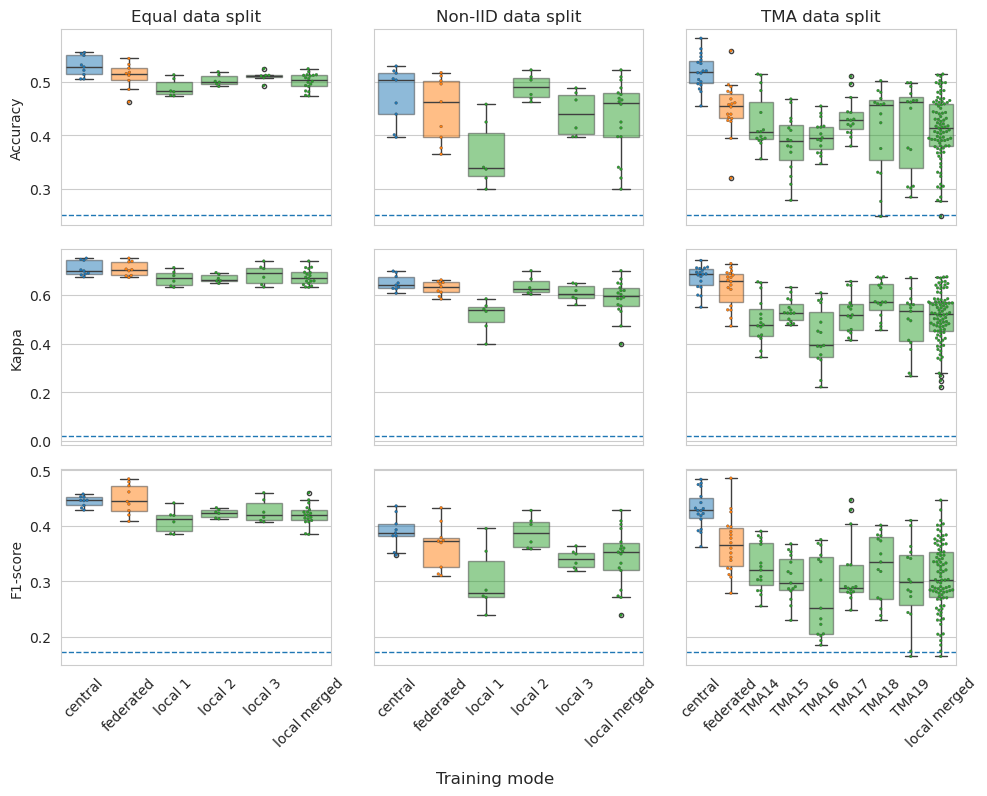

In [46]:
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

def plot_supp1(df, ax, metric, mode=""):
    if mode == "TMA":
        custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c"]
    else:
        custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#2ca02c", "#2ca02c", "#2ca02c"]
            
    sns.boxplot(x='mode', y=metric, dodge=True, data=df, ax=ax, **boxplot_kwargs)
    for i, patch in enumerate(ax.patches):
        patch.set_facecolor(custom_colors[i])
    sns.swarmplot(x='mode', y=metric, data=df, ax=ax, palette=custom_colors, edgecolor="gray", linewidth=0.2, size=2)

    ax.axhline(baseline[metric], linestyle="--", linewidth=1)
    ax.set_xlabel("")
    ax.set_xticklabels([])

def create_suppfigure1(upper_df, middle_df, lower_df):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharey="row")
    for i, metric in enumerate(metrics):
        plot_supp1(upper_df, axes[i][0], metric)
        plot_supp1(middle_df, axes[i][1], metric)
        plot_supp1(lower_df, axes[i][2], metric, mode="TMA")

        axes[i][0].set_ylabel(f"{metric.capitalize()}")

    axes[0][0].set_title("Equal data split")
    axes[0][1].set_title("Non-IID data split")
    axes[0][2].set_title("TMA data split")
    
    axes[2][0].set_xticklabels(["central", "federated", "local 1", "local 2", "local 3", "local merged"], rotation=45)
    axes[2][1].set_xticklabels(["central", "federated", "local 1", "local 2", "local 3", "local merged"], rotation=45)
    axes[2][2].set_xticklabels(["central", "federated", "TMA14", "TMA15", "TMA16", "TMA17", "TMA18", "TMA19", "local merged"], rotation=45)
    
    fig.supxlabel("Training mode")
    plt.tight_layout()
    plt.savefig(os.path.join("run_results", "Supp_Figure1.png"), dpi=300)

create_suppfigure1(equal_df, nonIID_df, TMA_df)